# Group 7
- Yimin Xu (5696925)
- Zhenlin Xu (5721679)
- Xinghao Lou (5698715)

## Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp

%matplotlib inline

## Read Dataset

In [2]:
aircraft_info = pd.read_csv("./Group7_data/Aircraft_info.csv")
aircraft_info

,AC_type,Speed,Seats,TAT,Charging,Range,Runway,Lease_c,Operating_c,Time_c,Fuel_c,Energy_c
0,Regional Turboprop,550,45,25,0,1500,1400,15000,300,750,1.00,0
1,Regional Jet,820,70,35,0,3300,1600,34000,600,775,2.00,0
2,Single Aisle Twin Engine Jet,850,150,45,0,6300,1800,80000,1250,1400,3.75,0
3,Electric twinprop aircraft,350,20,20,20,400,750,12000,90,750,0.00,2130
4,Electric regional aircraft,480,48,25,45,1000,950,22000,120,750,0.00,8216


In [3]:
distance = pd.read_csv("./Group7_data/Group_7_Distances.csv", index_col=0).to_numpy()
distance.shape

(15, 15)

In [4]:
airport_info = pd.read_csv('Group7_data/Group_7_Airport_info.csv', index_col=1)
airport_info

,City Name,Latitude (deg),Longitude (deg),Runway (m),Population,GDP
ICAO Code,,,,,,
LIME,Bergamo,45.668889,9.700278,2937,11756152,468.77
LIBD,Bari,41.136600,16.756400,3000,2921914,77.47
LIMF,Torino,45.200499,7.643164,3300,477617,137.78
LIRQ,Firenze,43.808653,11.201225,1750,5827084,118.72
LICJ,Palermo,38.182400,13.100582,3326,1880634,89.36
LIPZ,Venezia,45.503200,12.351200,3300,5658163,164.86
LIPY,Ancona,43.616943,13.516667,2962,2281970,42.39
LIRN,Napoli,40.884000,14.287800,2012,6282927,109.63
LIPX,Verona,45.395699,10.888500,3068,9002561,38.77


## Parameters

In [5]:
# parameters
ac_type = 3
num_airport = 15
hub_index = 0
LF = 0.8  # load_factor
BT = 70

demand = np.load("./Outputs/demand.npz.npy")
# assert demand.shape == (num_airport, num_airport)

TAT = aircraft_info["TAT"].to_numpy()
speeds = aircraft_info["Speed"].to_numpy()
seats = aircraft_info["Seats"].to_numpy()  # num_seat
ranges = aircraft_info["Range"].to_numpy()
lease_c = aircraft_info["Lease_c"].to_numpy()
operate_c = aircraft_info["Operating_c"].to_numpy()
time_c = aircraft_info["Time_c"].to_numpy()
fuel_c = aircraft_info["Fuel_c"].to_numpy()
fuel_price = 1.42

# if hub exists (binary) g_ij
g = [0,] + [1,] * (num_airport-1)
# assert g.__len__() == num_airport

## Create the model

In [6]:
model = gp.Model(name="Leg-based model")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-11


### Declare decision variables

In [7]:
# ----- create decision variables -----

# Z_ij^k:
# number of flights from airport i to airport j 
Z = [[[ 0 for _ in range(ac_type)] for _ in range(num_airport)] for _ in range(num_airport)]
for row in range(num_airport):
    for col in range(num_airport):
        for ac in range(ac_type):
            Z[row][col][ac] = model.addVar(lb=0, vtype=gp.GRB.INTEGER, name="#Z("+str(row)+','+str(col)+','+str(ac)+')')
        
assert len(Z) == num_airport
assert len(Z[0]) == num_airport
assert len(Z[0][0]) == ac_type

# X_ij:
# direct flow from airport i to airport j 
X = [[0 for _ in range(num_airport)] for _ in range(num_airport)]
for row in range(num_airport):
    for col in range(num_airport):
        X[row][col] = model.addVar(lb=0, vtype=gp.GRB.INTEGER,name="#X("+str(row)+','+str(col)+')')
# W_ij:
# connected flow from airport i to airport j that transfer at hub
W = [[0 for _ in range(num_airport) ] for _ in range(num_airport)]
for row in range(num_airport):
    for col in range(num_airport):
        W[row][col] = model.addVar(lb=0, vtype=gp.GRB.INTEGER,name="#W("+str(row)+','+str(col)+')')

# AC^k
# number of aircraft ac_type k
AC = [0 for _ in range(ac_type)]
for ac in range(ac_type):
    AC[ac] = model.addVar(lb=0, vtype=gp.GRB.INTEGER)
            
# ----- create decision variables -----

model.update()

### Add constraints

In [8]:
# ----- add constraints -----

# x_ii and w_ii = 0
for i in range(num_airport):
    model.addConstr(X[i][i] == 0)
    model.addConstr(W[i][i] == 0)
    for k in range(ac_type):
        model.addConstr(Z[i][i][k] == 0)

c1 = []
for i in range(num_airport):
    for j in range(num_airport):
        c1.append(
            model.addConstr(X[i][j] + W[i][j] <= demand[i][j])
        )
        
# c1*
c1_star = []
for i in range(num_airport):
    for j in range(num_airport):
        c1_star.append(
            model.addConstr(W[i][j] <= demand[i][j] * g[i] * g[j])
        )
print('---- Add DEMAND Constraints ----')

---- Add DEMAND Constraints ----


In [9]:
# c2
c2 = []
for i in range(num_airport):
    for j in range(num_airport):
        c2.append(
            model.addConstr(
                X[i][j] + sum([ W[i][m]*(1-g[j]) for m in range(num_airport)]) +
                sum([ W[m][j]*(1-g[i]) for m in range(num_airport)]) <=
                sum([Z[i][j][k]* seats[k] * LF for k in range(ac_type)]))
            )
print('---- Add CAPACITY Constraints ----')

---- Add CAPACITY Constraints ----


In [10]:
# c3
c3 = []
for i in range(num_airport):
    for k in range(ac_type):
        c3.append(
            model.addConstr(
                sum([ Z[i][j][k] for j in range(num_airport)]) == sum([ Z[j][i][k] for j in range(num_airport)]
            )))
print('---- Add FLOW Constraints ----')

---- Add FLOW Constraints ----


In [11]:
# c4
c4 = []
for k in range(ac_type):
    c4.append(
        model.addConstr(
            BT * AC[k] >= 
            sum([(distance[i][j] / speeds[k] + TAT[k]/60) * Z[i][j][k] for i in range(num_airport) for j in range(1, num_airport)]) +
            sum([(distance[i][0] / speeds[k] + 1.5*TAT[k]/60) * Z[i][0][k] for i in range(num_airport)])
        )
    )
print('---- Add UTIL Constraints ----')

---- Add UTIL Constraints ----


In [12]:
# c5
c5 = []
for i in range(num_airport):
    for j in range(num_airport):
        for k in range(ac_type):
            a_ijk = 10000 if distance[i][j] <= ranges[k] else 0
            c5.append(
                model.addConstr(
                    Z[i][j][k] <= a_ijk
                )
            )
print('---- Add RANGE Constraints ----')

model.update()
# ----- add constraints -----

---- Add RANGE Constraints ----


### Set objective (revenue / costs)

In [13]:
# ----- add objective function -----
revenue = gp.quicksum((5.9 * distance[i][j]**(-0.76) + 0.043) * distance[i][j] *(X[i][j] + W[i][j]) for i in range(num_airport) for j in range(num_airport) if i != j) 

leasing_cost = gp.quicksum(lease_c[k] * AC[k] for k in range(ac_type))

fixed_operation_cost = gp.quicksum((operate_c[k] * 
                        (gp.quicksum(Z[i][j][k] for i in range(1,num_airport) for j in range(1,num_airport)) +
                            0.7 * gp.quicksum(Z[i][0][k] for i in range(1, num_airport)) +
                            0.7 * gp.quicksum(Z[0][j][k] for j in range(1, num_airport))))
                               for k in range(ac_type))

timebased_cost = gp.quicksum(time_c[k]/speeds[k] * 
                    (gp.quicksum(distance[i][j]*Z[i][j][k] for i in range(1,num_airport) for j in range(1,num_airport)) +
                        0.7 * gp.quicksum(distance[i][0]*Z[i][0][k] for i in range(1, num_airport)) +
                        0.7 * gp.quicksum(distance[0][j]*Z[0][j][k] for j in range(1, num_airport)))
                            for k in range(ac_type))

fuel_cost = gp.quicksum(fuel_c[k] * fuel_price / 1.5 * 
                        (gp.quicksum(distance[i][j]*Z[i][j][k] for i in range(1,num_airport) for j in range(1,num_airport)) +
                            0.7 * gp.quicksum(distance[i][0]*Z[i][0][k] for i in range(1, num_airport)) +
                            0.7 * gp.quicksum(distance[0][j]*Z[0][j][k] for j in range(1, num_airport)))
                                for k in range(ac_type))

model.setObjective(
    revenue 
    - fixed_operation_cost 
    - timebased_cost
    - fuel_cost
    - leasing_cost
)
model.modelSense = gp.GRB.MAXIMIZE

# ----- add objective function -----
model.update()

# ----- configure the solver -----
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1473 rows, 1128 columns and 4712 nonzeros
Model fingerprint: 0x4d5b5200
Variable types: 0 continuous, 1128 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+02]
  Objective range  [2e+01, 8e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 1033 rows and 103 columns
Presolve time: 0.01s
Presolved: 440 rows, 1025 columns, 3420 nonzeros
Variable types: 0 continuous, 1025 integer (0 binary)

Root relaxation: objective 7.193047e+04, 606 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 71930.4665    0  135   -0.00000 71930.4665      -     -    0s
H    0     0              

In [14]:
# output the log files

# import platform
# gp.setParam('OutputFlag', 1)
# gp.setParam("LogToConsole", 1)
# if platform.system() == 'Windows':
#     model.write(f'./Logs/model_{platform.system()}.mps')
#     model.write(f"./Logs/model_{platform.system()}.lp")
# else:
#     model.write(f'./Logs/model_{platform.system()}.mps')
#     model.write(f"./Logs/model_{platform.system()}.lp")

### Optimal solution value

In [15]:
model.ObjVal 

64166.01293244949

In [16]:
ac = np.zeros(3,)
for k in range(ac_type):
    print(f"Using AC Type {k}:", int(AC[k].X))
    ac[k] = AC[k].X

assert ac.shape == (3,)
np.save("./Outputs/leg-ac.npz", ac)

Using AC Type 0: 3
Using AC Type 1: 1
Using AC Type 2: 0


In [17]:
revenue = revenue.getValue()
print(leasing_cost.getValue(), fixed_operation_cost.getValue(), timebased_cost.getValue(), fuel_cost.getValue())
cost = fixed_operation_cost.getValue() + timebased_cost.getValue() + fuel_cost.getValue()
revenue, cost

79000.0 92220.0 87473.44240290335 90783.59539808282


(413643.0507334358, 270477.03780098615)

In [18]:
total = 0
x = np.zeros((num_airport, num_airport))
print("X:")
for i in range(num_airport):
    for j in range(num_airport):
        print(f"{X[i][j].X:8.0f}", end=' ')
        total += X[i][j].X
        x[i,j] = X[i][j].X
    print()
print(total)
assert x.shape == (num_airport, num_airport)
np.save("./Outputs/leg-x-ij.npz", x)

X:
       0      112      104      210       96      226      118      160      269       69      252       81      109      178      101 
     112        0        0       56       56        0       56      108        0        0        0       36       56        0       36 
     104        0        0       36        0        0        0        0       36        0       56        0        0       36        0 
     210       56       36        0        0      144       72      112      144       36      180        0        0      108       72 
      96       56        0        0        0        0        0       72        0        0        0       36       72        0        0 
     226        0        0      144        0        0       72        0      176        0      180        0        0       72       72 
     118       56        0       72        0       72        0       72       72        0       72        0        0       56       36 
     160      108        0      112       72 

In [19]:
total = 0
w = np.zeros((num_airport, num_airport))
print("W")
for i in range(num_airport):
    for j in range(num_airport):
        print(f"{W[i][j].X:8.0f}", end=' ')
        total += W[i][j].X
        w[i,j] = W[i][j].X
    print()
print(total)
assert w.shape == (num_airport, num_airport)
np.save("./Outputs/leg-w-ij.npz", w)

W
       0        0        0        0        0        0        0        0        0        0        0        0        0        0        0 
       0        0        0        0        0        0        0        0        0        0        0        0        0        0        0 
       0        0        0        6        6       26       26        8        3        0        0       23        3        0       11 
       0        0        6        0        0        0        0        0        0        0        0        0        0        0        0 
       0        0        9        0        0        0        0        0        7        0        0        0        0        0        0 
       0        0       26        0        0        0        0        0        0        0        0        0        0        0        0 
       0        0       26        0        0        0        0        0        0        0        0        0        0        0        0 
       0        0        8        0        0  

In [20]:
total = 0
z = np.zeros((ac_type, num_airport, num_airport))
for i in range(num_airport):
    for j in range(num_airport):
        for k in range(ac_type):
            total += Z[i][j][k].X
            z[k,i,j] = Z[i][j][k].X
print("Z", total)
assert z.shape == (ac_type, num_airport, num_airport)
np.save("./Outputs/leg-z-ijk.npz", z)

for k in range(ac_type):
    for i in range(num_airport):
        for j in range(num_airport):
            print(f"{Z[i][j][k].X:6.0f}", end=' ')
        print()
    print()

Z 300.0
     0      0      6      6      0      7      4      0      8      2      7      0      0      5      0 
     0      0      0      0      0      0      0      3      0      0      0      1      0      0      1 
     6      0      0      1      0      0      0      0      1      0      0      0      0      1      0 
     6      0      1      0      0      4      2      0      4      1      5      0      0      3      2 
     0      0      0      0      0      0      0      2      0      0      0      1      2      0      0 
     7      0      0      4      0      0      2      0      5      0      5      0      0      2      2 
     4      0      0      2      0      2      0      2      2      0      2      0      0      0      1 
     0      3      0      0      2      0      2      0      0      1      0      2      1      0      2 
     8      0      1      4      0      5      2      0      0      0      5      0      0      3      0 
     2      0      0      1      0    

# Load the solution

In [21]:
x = np.load("./Outputs/leg-x-ij.npz.npy") #.reshape(( num_airports, num_airports))
w = np.load("./Outputs/leg-w-ij.npz.npy") #.reshape((ac_type, num_airports, num_airports))
z = np.load("./Outputs/leg-z-ijk.npz.npy").reshape((ac_type, num_airport, num_airport))
ac = np.load("./Outputs/leg-ac.npz.npy")
print("X:",x.shape)
print("W:",w.shape)
print("Z:",z.shape)
print("AC:", ac.shape)

X: (15, 15)
W: (15, 15)
Z: (3, 15, 15)
AC: (3,)


# Calculate the KPIs

In [22]:
ASK = np.stack([distance * seats[ac]*z[ac] for ac in range(ac_type)])
np.save("./Outputs/leg-ASK-ijk.npz", ASK)
ASK_total = ASK.sum()
ASK_total

4503901.3698189445

In [23]:
distance = pd.read_csv("./Group7_data/Group_7_Distances.csv", index_col=0).to_numpy()
flow = x + w
# print(flow.sum(), distance.sum())
RPK = flow * distance
RPK_total = RPK.sum()
RPK_total

3581626.22809293

In [24]:
# COST = np.zeros((ac_type,num_airport,num_airport))
# for k in range(ac_type):
#     for idx in range(num_airport):
#         for jdx in range(num_airport):
#             fixed_operation_cost = operate_c[k] * z[k,idx, jdx]
#             timebased_cost = time_c[k]*distance[idx,jdx]*z[k,idx,jdx]/speeds[k]
#             fuel_cost = fuel_c[k] * fuel_price * distance[i][j] * z[k][idx][jdx] /1.5
#             COST[k,idx,jdx] = fixed_operation_cost + timebased_cost + fuel_cost
z = np.load("./Outputs/leg-z-ijk.npz.npy")

CASK = cost / ASK_total
CASK

0.06005394336862648

In [25]:
# REVENUE = np.zeros((ac_type,num_airport,num_airport))

# for k in range(ac_type):
#     for idx in range(num_airport):
#         for jdx in range(num_airport):
#             if idx != jdx :
#                 revenue = (5.9 * distance[idx][jdx]**(-0.76) + 0.043) * distance[idx][jdx] * (x[idx,jdx] + w[idx, jdx])
#                 REVENUE[k,idx,jdx] = revenue
# revenue = gp.quicksum((5.9 * distance[i,j]**(-0.76) + 0.043) * distance[i,j] *(x[i][j] + w[i][j]) for i in range(num_airport) for j in range(num_airport) if i != j) 

RASK = revenue/ASK_total
RASK

0.0918410544034769

In [26]:
LF = RPK_total/ASK_total
LF

0.7952275003386475

In [27]:
UnitProfit = RASK - CASK
UnitProfit

0.031787111034850414

In [28]:
OperationalProfit = UnitProfit * ASK_total
OperationalProfit

143166.01293244967

# Visualize the flight and flow using geopandas/matplotlib

In [29]:
lat = airport_info['Latitude (deg)']
lon = airport_info['Longitude (deg)']
# plt.scatter(lat, lon)

### Geoplot for ac type 1

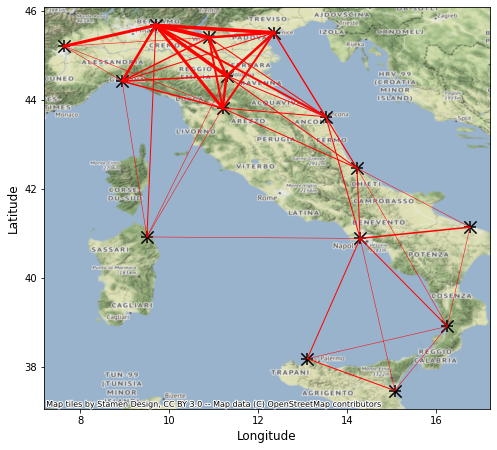

In [30]:
import geopandas 
import contextily as ctx
import xyzservices.providers as xyz
import scienceplots

z = np.load("./Outputs/leg-z-ijk.npz.npy").reshape((ac_type, num_airport, num_airport))

# plt.style.use(['ieee'])
# n = 100
# col = pl.cm.jet([0.25,0.75])    
# colors = plt.cm.jet(np.linspace(0,1,n))

airports = geopandas.GeoDataFrame(
    data=airport_info,
    crs='EPSG:4326',
    geometry=geopandas.points_from_xy(airport_info['Longitude (deg)'], airport_info['Latitude (deg)']))
# airports.set_crs(epsg=4326)

crs=airports.crs.to_string()
ax = airports.plot(figsize = (8,8), markersize=150, marker='x', color='black')
ctx.add_basemap(
    ax, 
    url=ctx.providers.Stamen.TonerLite,
    crs=airports.crs.to_string(),
    # source=ctx.providers.Stamen.TonerLite
)

plt.xlabel('Longitude', fontdict={'size': 12,})
plt.ylabel('Latitude', fontdict={'size': 12,})
# plt.title('The flights using aircraft type 1', fontdict={'size': 16,})
# plt.xticks(fontdict={'size': 10,})

cnt = 0
for i in range(num_airport):
    for j in range(num_airport):
        if i >= j:
            if z[0][i,j] > 0:
                # print(z[1,i,j])
                plt.plot([lon[i], lon[j]], [lat[i], lat[j]], linewidth=z[0][i,j]/2, color='red', linestyle='solid')
                # cnt += 1
# print(cnt)
plt.scatter(airport_info['Longitude (deg)'], airport_info['Latitude (deg)'], marker='+', s=150, color='black')
                
plt.savefig("./Outputs/flight_1.png", dpi=300, bbox_inches='tight')

### Geoplot for ac type 2

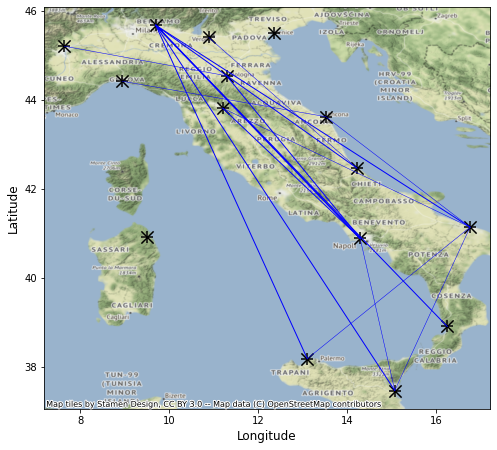

In [31]:
import geopandas 
import contextily as ctx
import xyzservices.providers as xyz
import scienceplots

z = np.load("./Outputs/leg-z-ijk.npz.npy").reshape((ac_type, num_airport, num_airport))

# plt.style.use(['ieee'])
# n = 100
# col = pl.cm.jet([0.25,0.75])    
# colors = plt.cm.jet(np.linspace(0,1,n))

airports = geopandas.GeoDataFrame(
    data=airport_info,
    crs='EPSG:4326',
    geometry=geopandas.points_from_xy(airport_info['Longitude (deg)'], airport_info['Latitude (deg)']))
# airports.set_crs(epsg=4326)

crs=airports.crs.to_string()
ax = airports.plot(figsize = (8,8), markersize=150, marker='x', color='black')
ctx.add_basemap(
    ax, 
    url=ctx.providers.Stamen.TonerLite,
    crs=airports.crs.to_string(),
    # source=ctx.providers.Stamen.TonerLite
)

plt.xlabel('Longitude', fontdict={'size': 12,})
plt.ylabel('Latitude', fontdict={'size': 12,})
# plt.title('The flights using aircraft type 3', fontdict={'size': 16,})
# plt.xticks(fontdict={'size': 10,})

cnt = 0
for i in range(num_airport):
    for j in range(num_airport):
        if i >= j:
            if z[1][i,j] > 0:
                # print(z[1,i,j])
                plt.plot([lon[i], lon[j]], [lat[i], lat[j]], linewidth=z[1][i,j]/2, color='blue', linestyle='solid')
                # cnt += 1
# print(cnt)
plt.scatter(airport_info['Longitude (deg)'], airport_info['Latitude (deg)'], marker='+', s=150, color='black')
                
plt.savefig("./Outputs/flight_2.png", dpi=300, bbox_inches='tight')

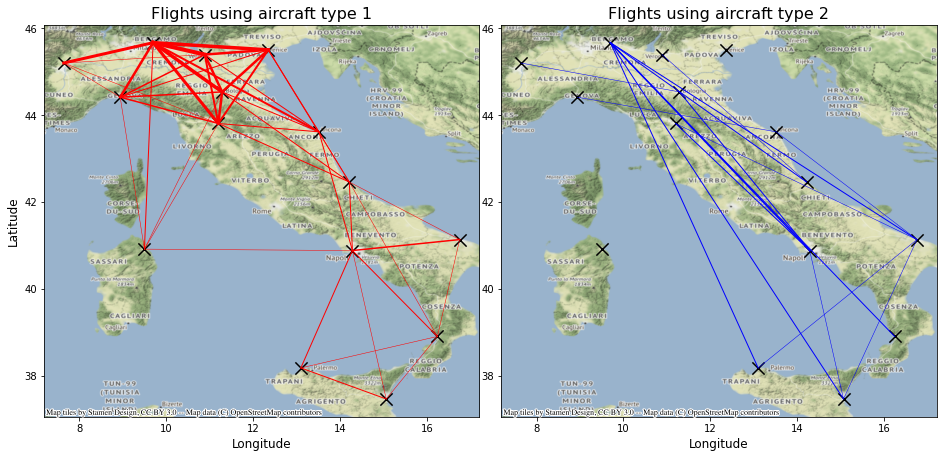

In [32]:
import geopandas 
import contextily as ctx
import xyzservices.providers as xyz
import scienceplots

fig, ax = plt.subplots(1,2,figsize=(16,8))

plt.style.use(['ieee'])
n = 60
col = plt.cm.jet([0.25,0.75])    
colors = plt.cm.jet(np.linspace(0,1,n))

airport_info = pd.read_csv("./Group7_data/Group_7_Airport_info.csv")
lat = airport_info['Latitude (deg)']
lon = airport_info['Longitude (deg)']

airports = geopandas.GeoDataFrame(
    data=airport_info,
    crs='EPSG:4326',
    geometry=geopandas.points_from_xy(airport_info['Longitude (deg)'], airport_info['Latitude (deg)']))
# airports.set_crs(epsg=4326)

crs=airports.crs.to_string()
airports.plot(figsize = (8,8), markersize=150, marker='x', color='black', ax=ax[0])
ctx.add_basemap(
    ax[0], 
    url=ctx.providers.Stamen.TonerLite,
    crs=airports.crs.to_string(),
    # source=ctx.providers.Stamen.TonerLite
)

ax[0].set_xlabel('Longitude', fontdict={'size': 12,})
ax[0].set_ylabel('Latitude', fontdict={'size': 12,})
ax[0].set_title('Flights using aircraft type 1', fontdict={'size': 16,})

# plt.title('The routes used in the optimal solution', fontdict={'size': 16,})
# plt.xticks(fontdict={'size': 10,})

for i in range(num_airport):
    for j in range(num_airport):
        if i >= j:
            if z[0][i,j] > 0:
                # print(z[1,i,j])
                ax[0].plot([lon[i], lon[j]], [lat[i], lat[j]], linewidth=z[0][i,j]/2, color='red', linestyle='solid')
                cnt += 1

airports.plot(figsize = (8,8), markersize=150, marker='x', color='black', ax=ax[1])
ctx.add_basemap(
    ax[1], 
    url=ctx.providers.Stamen.TonerLite,
    crs=airports.crs.to_string(),
    # source=ctx.providers.Stamen.TonerLite
)
ax[1].set_xlabel('Longitude', fontdict={'size': 12,})
# ax[1].set_ylabel('Latitude', fontdict={'size': 12,})
ax[1].set_title('Flights using aircraft type 2', fontdict={'size': 16,})
# plt.xlabel('Longitude', fontdict={'size': 12,})
# plt.ylabel('Latitude', fontdict={'size': 12,})
# plt.title('The routes used in the optimal solution', fontdict={'size': 16,})
# plt.xticks(fontdict={'size': 10,})

for i in range(num_airport):
    for j in range(num_airport):
        if i >= j:
            if z[1][i,j] > 0:
                # print(z[1,i,j])
                ax[1].plot([lon[i], lon[j]], [lat[i], lat[j]], linewidth=z[1][i,j]/2, color='blue', linestyle='solid')
                cnt += 1
# cnt = 0
# for i, (idx, row, col) in enumerate(route_ids):
#     # print( i, R_dict[row, col], int(z[row, col]))
#     if not R[row].isTriangle and col==1:
#         lon_list, lat_list = [], []
#         for node in R[row].route:
#             lon_list.append(lon[node])
#             lat_list.append(lat[node])
#         ax[1].plot(lon_list, lat_list, linewidth=z[row, col], color=colors[cnt], linestyle='solid' ,)
#         cnt += 1
        
# plt.scatter(airport_info['Longitude (deg)'], airport_info['Latitude (deg)'], marker='+', s=150, color='black')
fig.subplots_adjust(wspace=0.05)                
plt.savefig("./Outputs/flights-12.png", dpi=300, bbox_inches='tight')

In [33]:
# n = 1000
# # col = pl.cm.jet([0.25,0.75])    
# colors = plt.cm.jet(np.linspace(0,1,n))

# airports = geopandas.GeoDataFrame(
#     data=airport_info,
#     crs='EPSG:4326',
#     geometry=geopandas.points_from_xy(airport_info['Longitude (deg)'], airport_info['Latitude (deg)']))
# # airports.set_crs(epsg=4326)

# crs=airports.crs.to_string()
# ax = airports.plot(figsize = (8,8), markersize=150, marker='x', color='black')
# ctx.add_basemap(
#     ax, 
#     url=ctx.providers.Stamen.TonerLite,
#     crs=airports.crs.to_string(),
#     # source=ctx.providers.Stamen.TonerLite
# )
# plt.xlabel('Longitude', fontdict={'size': 12,})
# plt.ylabel('Latitude', fontdict={'size': 12,})
# plt.title('The total flow between each O-D pair', fontdict={'size': 16,})

# cnt = 750
# for i in range(num_airport):
#     for j in range(num_airport):
#         if i != j:
#             if x[i,j] + w[i,j]> 0:
#                 # print(cnt)
#                 plt.plot([lon[i], lon[j]], [lat[i], lat[j]], linewidth=(x[i,j]+w[i,j])/100, color='red', linestyle='solid')
#                 cnt += 1
                
# plt.scatter(airport_info['Longitude (deg)'], airport_info['Latitude (deg)'], marker='+', s=150)
# # plt.savefig("./Outputs/TotalFlow.png", dpi=300, bbox_inches='tight')

# Visualize the heatmap

### $X_{ij}$, $W_{ij}$

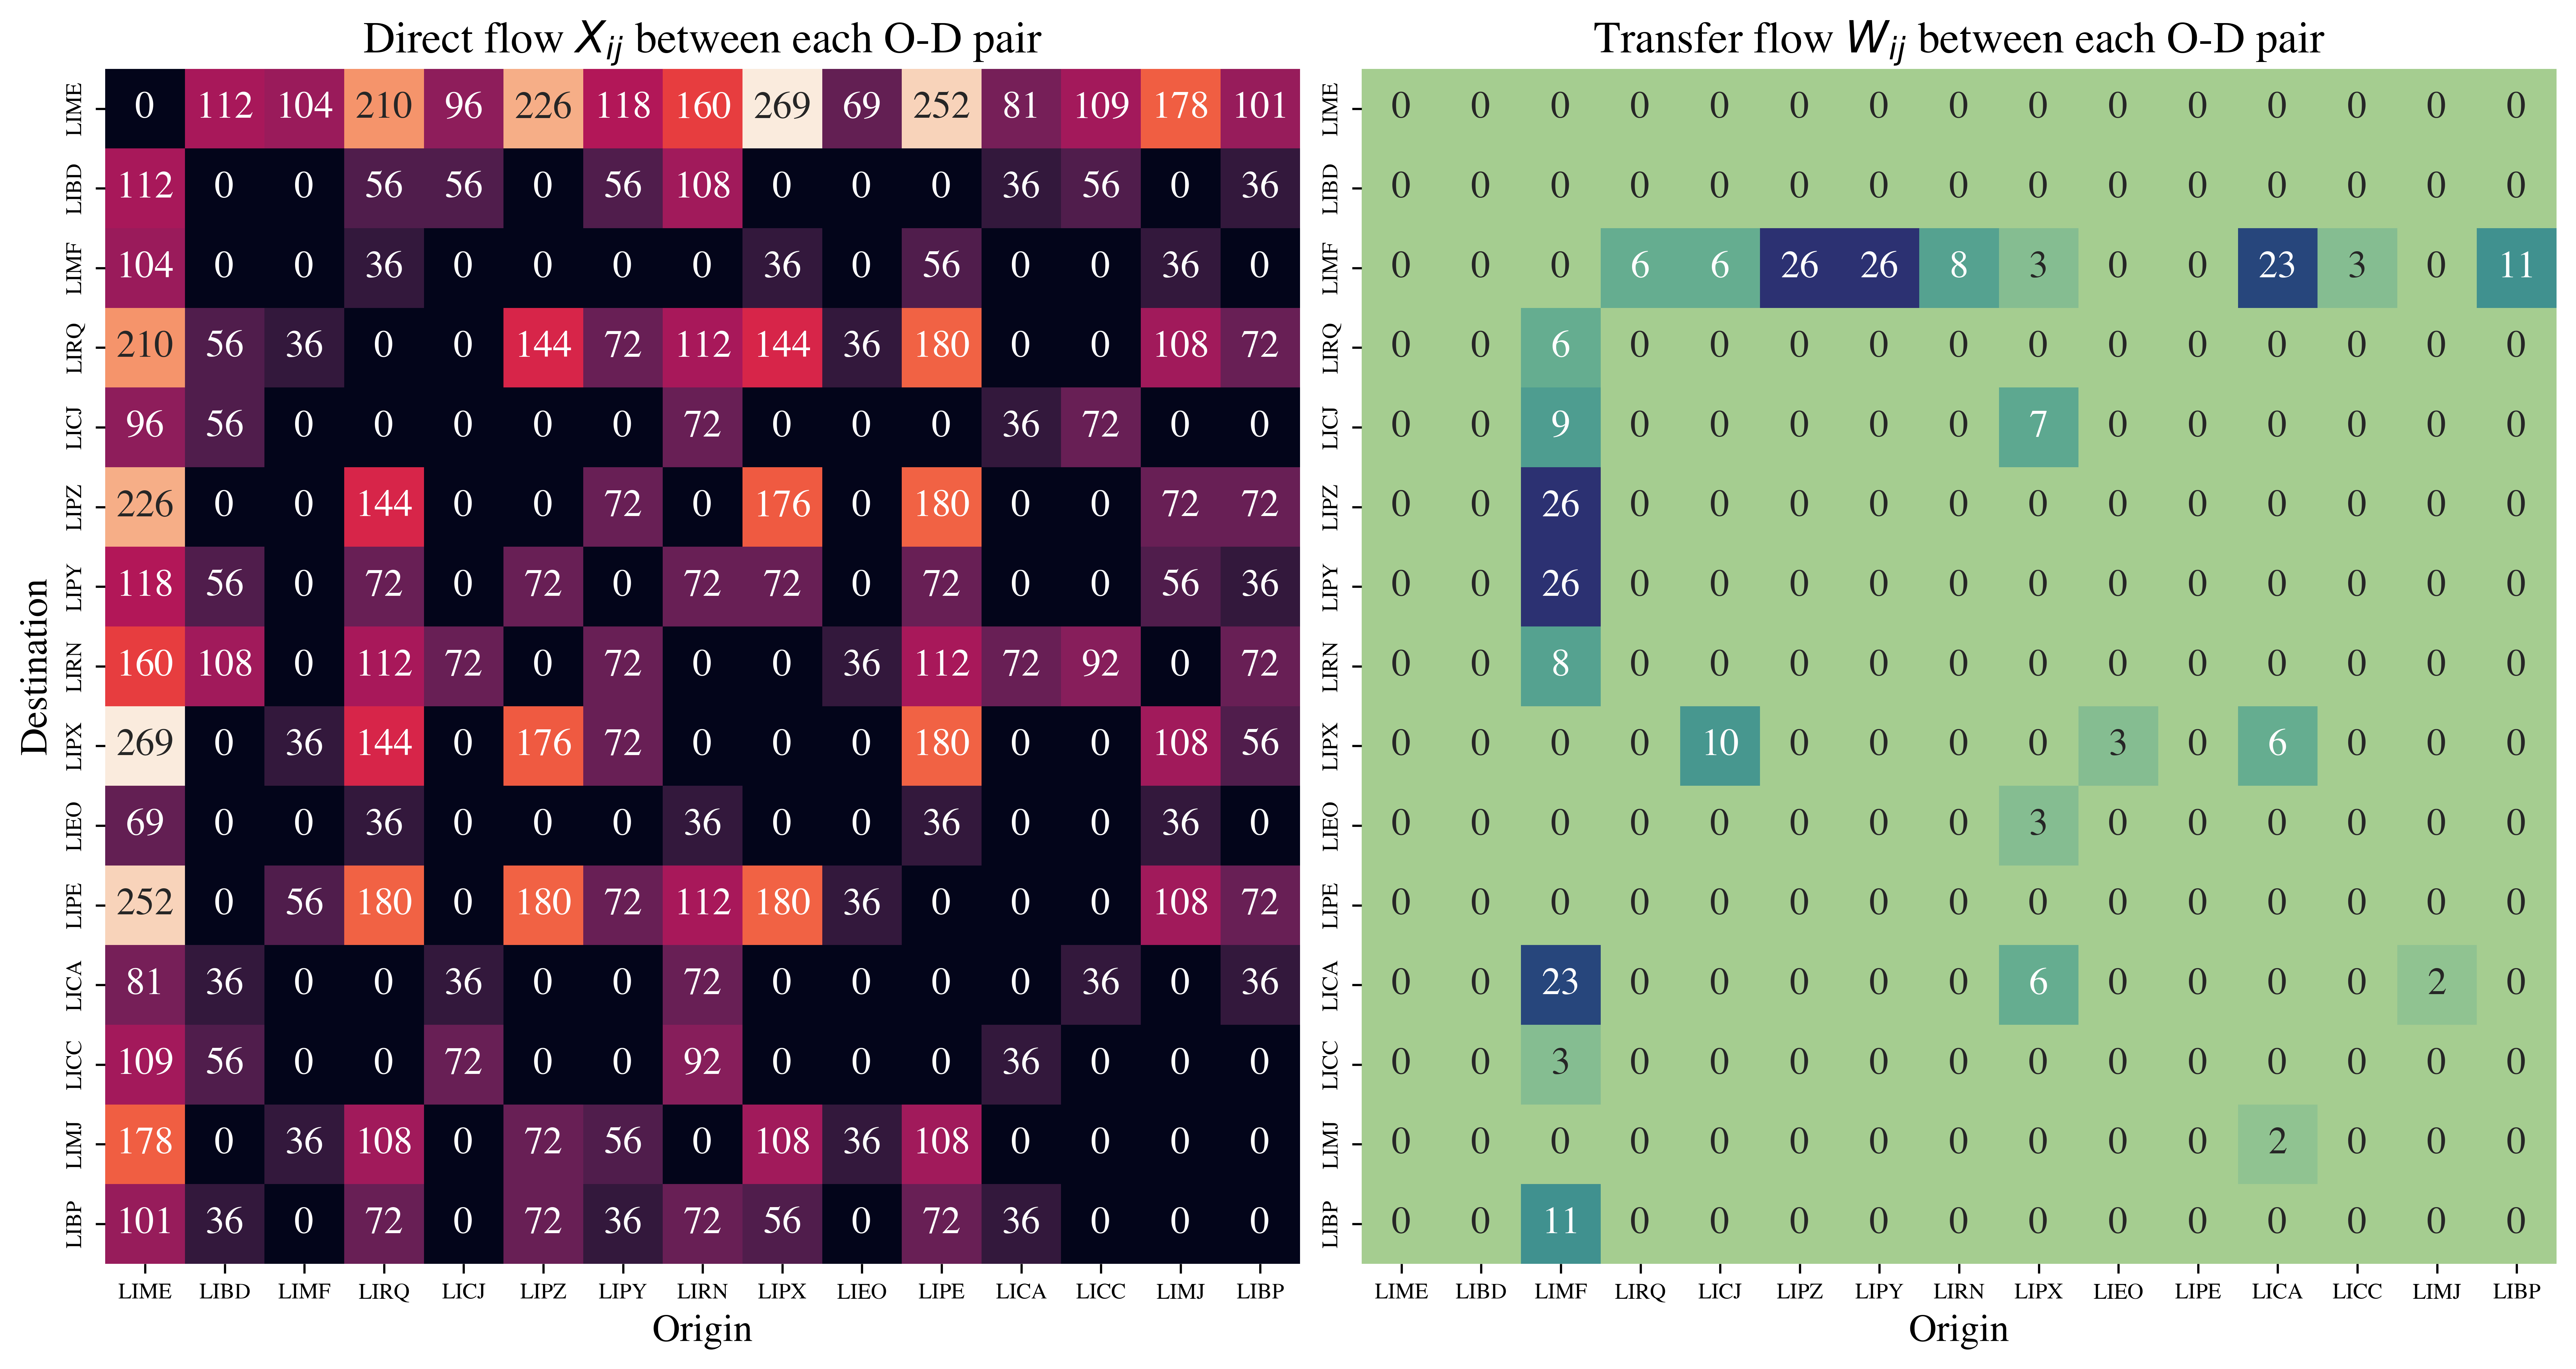

In [34]:
import seaborn as sns
fig, ax = plt.subplots(1,2,figsize=(16,8))
distance = pd.read_csv("./Group7_data/Group_7_Distances.csv", index_col=0)

sns.heatmap(
    abs(x),
    ax=ax[0],
    annot=True,
    fmt=".0f",
    square=True,
    xticklabels=list(distance.columns), 
    yticklabels=list(distance.columns),
    # cmap="crest",
    cbar=False,
    annot_kws={
    'fontsize': 14,
    # 'fontweight': 'bold',
    # 'fontfamily': 'serif'
    }
)
ax[0].set_title('Direct flow $X_{ij}$ between each O-D pair', fontdict={'size': 16,})
ax[0].set_xlabel('Origin', fontdict={'size': 14,})
ax[0].set_ylabel('Destination', fontdict={'size': 14,})
sns.heatmap(
    abs(w),
    ax=ax[1],
    annot=True,
    fmt=".0f",
    square=True,
    xticklabels=list(distance.columns), 
    yticklabels=list(distance.columns),
    cmap="crest",
    cbar=False,
    annot_kws={
    'fontsize': 14,
    # 'fontweight': 'bold',
    # 'fontfamily': 'serif'
    }
)
ax[1].set_title('Transfer flow $W_{ij}$ between each O-D pair', fontdict={'size': 16,})
ax[1].set_xlabel('Origin', fontdict={'size': 14,})
# ax[1].set_ylabel('Destination', fontdict={'size': 14,})
fig.subplots_adjust(wspace=0.05)
fig.savefig('./Outputs/leg-XW_ij.png', dpi=300, bbox_inches='tight')

### $Z_{ij}^0$, $Z_{ij}^1$

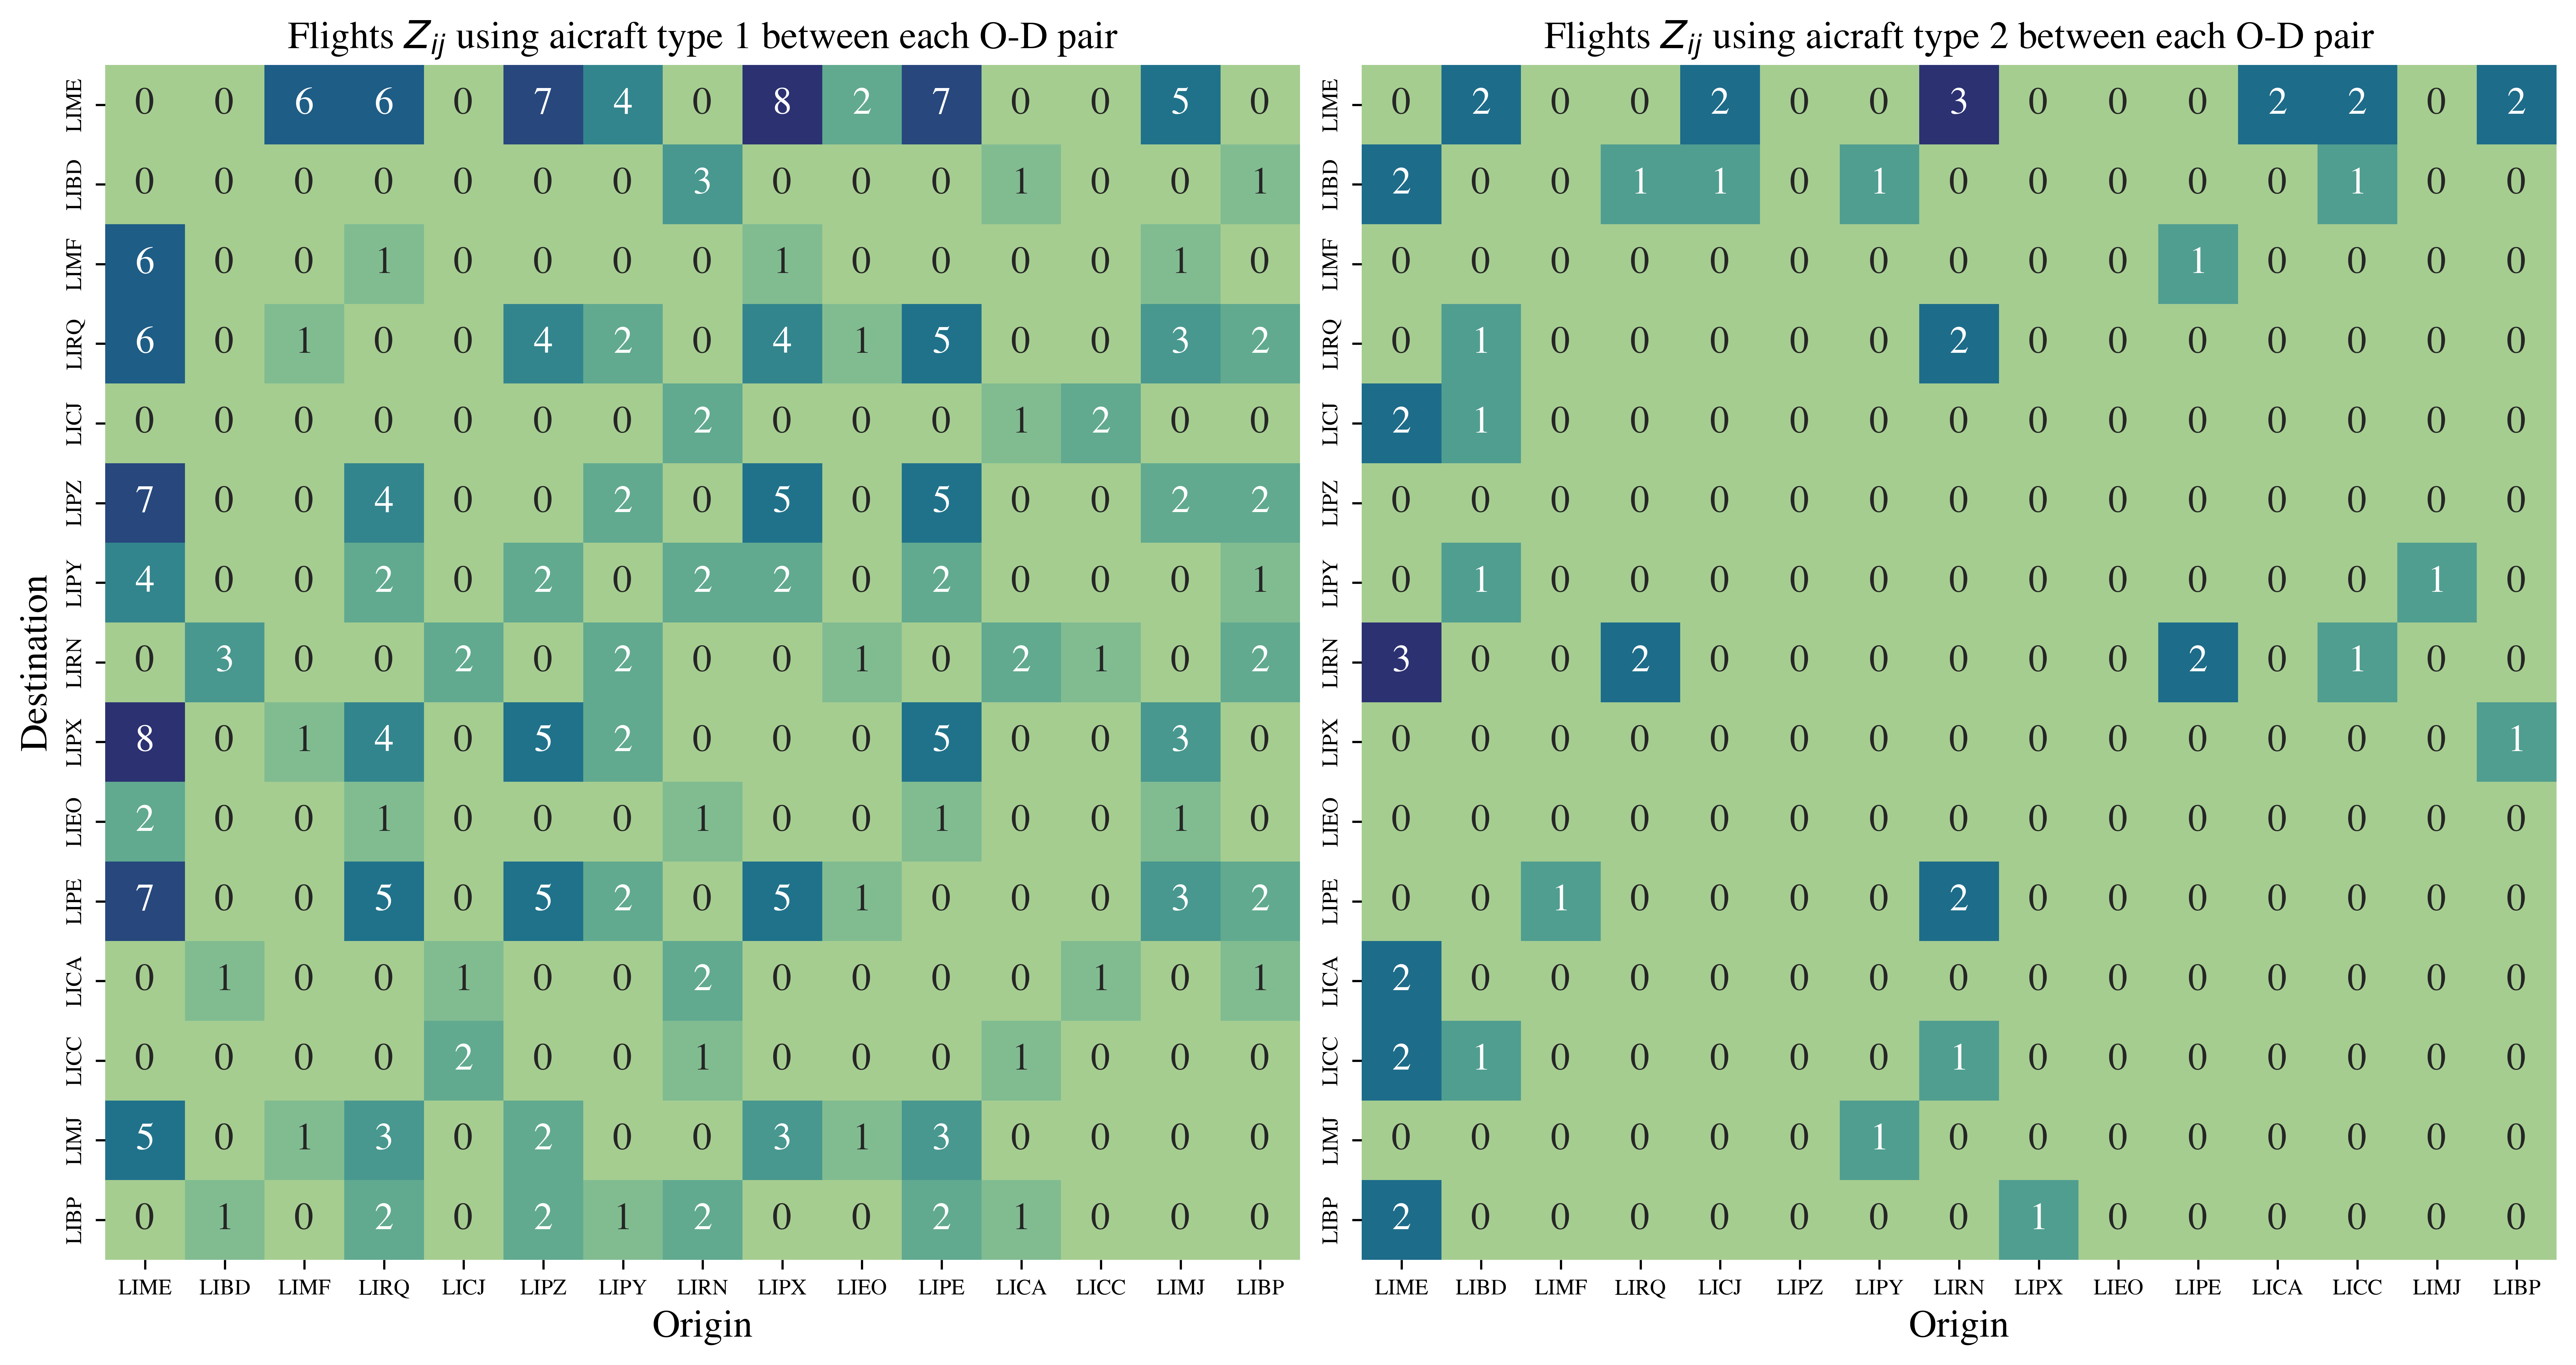

In [35]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

sns.heatmap(
    abs(z[0]),
    ax=ax[0],
    annot=True,
    fmt=".0f",
    square=True,
    xticklabels=list(distance.columns), 
    yticklabels=list(distance.columns),
    cmap="crest",
    cbar=False,
    annot_kws={
    'fontsize': 14,
    # 'fontweight': 'bold',
    # 'fontfamily': 'serif'
    }
)
ax[0].set_title('Flights $Z_{ij}$ using aicraft type 1 between each O-D pair', fontdict={'size': 14,})
ax[0].set_xlabel('Origin', fontdict={'size': 14,})
ax[0].set_ylabel('Destination', fontdict={'size': 14,})
# sns.heatmap(
#     z[1],
#     ax=ax[0,1],
#     annot=True,
#     fmt=".0f",
#     square=True,
#     xticklabels=list(distance.columns), 
#     yticklabels=list(distance.columns),
#     cmap="crest",
#     cbar=False,
#     annot_kws={
#     'fontsize': 14,
#     # 'fontweight': 'bold',
#     # 'fontfamily': 'serif'
#     }
# )
# ax[0,1].set_title('Flights $Z_{ij}$ using aicraft type 2 between each O-D pair', fontdict={'size': 14,})
# ax[0,1].set_xlabel('Origin', fontdict={'size': 12,})
# ax[0,1].set_ylabel('Destination', fontdict={'size': 12,})
sns.heatmap(
    z[1],
    ax=ax[1],
    annot=True,
    fmt=".0f",
    square=True,
    xticklabels=list(distance.columns), 
    yticklabels=list(distance.columns),
    cmap="crest",
    cbar=False,
    annot_kws={
    'fontsize': 14,
    # 'fontweight': 'bold',
    # 'fontfamily': 'serif'
    }
)
ax[1].set_title('Flights $Z_{ij}$ using aicraft type 2 between each O-D pair', fontdict={'size': 14,})
ax[1].set_xlabel('Origin', fontdict={'size': 14,})
# ax[1].set_ylabel('Destination', fontdict={'size': 12,})
# sns.heatmap(
#     abs(w+x),
#     ax=ax[1,1],
#     annot=True,
#     fmt=".0f",
#     square=True,
#     xticklabels=list(distance.columns), 
#     yticklabels=list(distance.columns),
#     # cmap="crest",
#     cbar=False,
#     annot_kws={
#     'fontsize': 14,
#     # 'fontweight': 'bold',
#     # 'fontfamily': 'serif'
#     }
# )
# ax[1,1].set_title('Flow $X_{ij}$ and $W_{ij}$ between each O-D pair', fontdict={'size': 14,})
# ax[1,1].set_xlabel('Origin', fontdict={'size': 12,})
# ax[1,1].set_ylabel('Destination', fontdict={'size': 12,})
fig.subplots_adjust(wspace=0.05, hspace=0.1)
fig.savefig('./Outputs/leg-ZXW.png', dpi=300, bbox_inches='tight')

In [36]:
# import seaborn as sns

# distance = pd.read_csv("./Group7_data/Group_7_Distances.csv", index_col=0)
# plt.style.use(['ieee'])
# plt.figure(figsize=(8,8))
# sns.heatmap(
#     x,
#     annot=True,
#     fmt=".0f",
#     square=True,
#     xticklabels=list(distance.columns), 
#     yticklabels=list(distance.columns),
#     cmap="crest"
# )
# plt.xlabel('Origin', fontdict={'size': 12,})
# plt.ylabel('Destination', fontdict={'size': 12,})
# plt.title('Directed flow between each O-D pair', fontdict={'size': 16,})
# # plt.show()
# plt.savefig('./Outputs/leg-X_ij.png', dpi=300, bbox_inches='tight')

In [37]:
# import seaborn as sns
# distance = pd.read_csv("./Group7_data/Group_7_Distances.csv", index_col=0)

# plt.style.use(['ieee'])
# plt.figure(figsize=(8,8))
# sns.heatmap(
#     w,
#     annot=True,
#     fmt=".0f",
#     square=True,
#     xticklabels=list(distance.columns), 
#     yticklabels=list(distance.columns),
#     cmap="crest"
# )
# plt.xlabel('Origin', fontdict={'size': 12,})
# plt.ylabel('Destination', fontdict={'size': 12,})
# plt.title('Transfering flow between each O-D pair', fontdict={'size': 16,})
# # plt.show()
# plt.savefig('./Outputs/leg-W_ij.png', dpi=300, bbox_inches='tight')